In [22]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

Shortest paths: {1: [1], 2: [1, 2], 3: [1, 2, 3], 4: [1, 2, 4], 6: [1, 2, 3, 6], 5: [1, 2, 4, 5]}


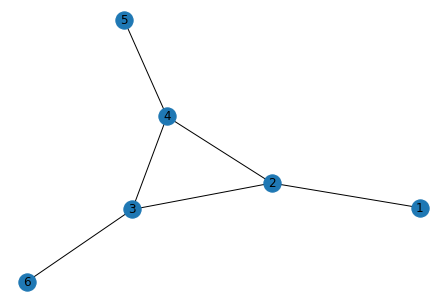

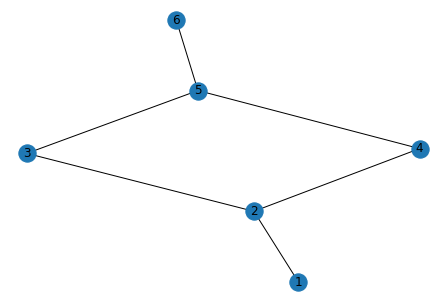

Shortest paths: {4: [4], 2: [4, 2], 5: [4, 5], 1: [4, 2, 1], 3: [4, 2, 3], 6: [4, 5, 6]}


In [23]:
import networkx as nx
import matplotlib.pyplot as plt

G1, G2 = nx.Graph(), nx.Graph()

G1.add_edges_from([
    (1, 2),
    (2, 3),
    (2, 4),
    (3, 4),
    (3, 6),
    (4, 5),
])

G2.add_edges_from([
    (1,2),
    (2,4),
    (2,3),
    (3,5),
    (4,5),
    (5,6)
])

paths1=nx.single_source_shortest_path(G1,1)
paths2=nx.single_source_shortest_path(G2,4)

plt.figure(1)
nx.draw(G1, with_labels=True)
print(f'Shortest paths: {paths1}')

plt.figure(2)
nx.draw(G2, with_labels=True)
plt.show()
print(f'Shortest paths: {paths2}')

In [24]:
from collections import defaultdict
import math


class Node:
    """Node class to store node and relevant information
    
    radius : lowest radius that this node is a part of
    measure : assigned measure for node
    path : shortest path from source
    name : label for node
    """
    
    def __init__(self):
        self.radius = 0
        self.measure = 0
        self.path = []
        self.name = None

    def __str__(self):
        return f"node {self.name}, radius {self.radius}"
    
    def __repr__(self):
        return f"node {self.name}, radius {self.radius}, measure {self.measure}"


def populate_node_list(shortest_paths):
    """Populate a list of nodes from a shortest_path dict
    
    Takes input typically from nx.single_source_shortest_path()
    Returns a list of Node objects
    """
    node_list = []
    for node in shortest_paths:
        n = Node()
        n.name = node
        n.path = shortest_paths[node]
        n.radius = len(shortest_paths[node]) - 1
        node_list.append(n)
    return node_list

        
def add_measures(list_of_nodes, measures):
    """Add measures to node_list
    
    Takes a list of Node objects and list of measure values
    """
    for i, n in enumerate(list_of_nodes):
        n.measure = measures[n.name - 1]


def get_CRD(list_of_nodes):
    """Calculate Cumulative Radial Distributions
    
    list_of_nodes : list of Node objects
    
    Returns a defaultdict radius->radial distribution
    """
    M = defaultdict(int)
    for n in list_of_nodes:
        M[n.radius] += n.measure
    for i in range(len(M) - 1):
        M[i + 1] += M[i]
    return M


def ensure_radial_parity(crd1, crd2):
    """Make sure both CRDs have the same maximum radius value"""
    if len(crd1) > len(crd2):
        length_difference = len(crd1) - len(crd2)
        for i in range(length_difference):
            crd2[len(crd2)+i] = crd2[len(crd2) - 1]
    elif len(crd2) > len(crd1): 
        length_difference = len(crd2) - len(crd1)
        for i in range(length_difference):
            crd1[len(crd1)+i] = crd1[len(crd1) - 1]


def get_CRD_union(crd1, crd2):
    """Takes two dictionaries and returns the union of their keys in a list"""
    union = set(crd1.keys()).union(set(crd2.keys()))
    return list(union)


def get_rdd(crd1, crd2):
    """Get the radial distribution distance for two CRDs
    
    Takes two cumulative radial distribution dictionaries as arguments.
    Returns a radial distribution distance float
    """
    CRD = get_CRD_union(crd1, crd2)
    rDD = 0
    for r in CRD:
        rDD = rDD + math.exp(-r)*abs(crd1[r] - crd2[r])
    return rDD

def get_rdd_const10(crd1, crd2):
    """Get the radial distribution distance for two CRDs
    
    Takes two cumulative radial distribution dictionaries as arguments.
    Returns a radial distribution distance float
    """
    CRD = get_CRD_union(crd1, crd2)
    rDD = 0
    for r in CRD:
        rDD = rDD + (10**(float(-2r)))*abs(crd1[r] - crd2[r])
    return rDD

def compare_node(G1, G2, v, u):
    """Calculate radial distribution distance
    
    G1 : graph
    G2 : graph
    v  : source node for shortest paths in G1
    u  : source node for shortest paths in G2 
    """
    paths1=nx.single_source_shortest_path(G1,v)
#     print(paths1)
    paths2=nx.single_source_shortest_path(G2,u)
#     print(paths2)
    node_list = populate_node_list(paths1)
#     print(node_list)
    add_measures(node_list, [1, 1, 2, 2, 1, 1])
    CRD1 = get_CRD(node_list)
    node_list = populate_node_list(paths2)
#     print(node_list)
    add_measures(node_list, [1, 1, 2, 2, 1, 1])
    CRD2 = get_CRD(node_list)
    ensure_radial_parity(CRD1, CRD2)
#     print(f'CRD for graph1: {CRD1}')
#     print(f'CRD for graph2: {CRD2}')
    print(f'Radial distribution distance: {v} and {u} {get_rdd(CRD1,CRD2)}')


for i in range(1,7):
    for j in range(1,7):
        compare_node(G1, G2, i, j)


SyntaxError: invalid syntax (<ipython-input-24-0d21cfaddc7e>, line 106)

In [25]:
real_network = nx.read_adjlist("facebook_combined.txt");

pHGraph1 = nx.Graph()
pHGraph2 = nx.Graph()


def realworld_distance_compare(network, first, second, radius, measure, network2=None):
    """Compares the radial distribution distance between two nodes in a single or two graphs.

    network : a networkx Graph object
    first : an instance of our Node class #  gets converted to string to match nx.Graph
    second : an instance of our Node class #  gets converted to string to match nx.Graph
    radius : the maximum radius we want to compare with
    """
    # Get the shortest paths for each node up to the specified radius
    real_paths1 = nx.single_source_shortest_path(network, str(first), radius)
    if network2:
        real_paths2 = nx.single_source_shortest_path(network2, str(second), radius)
    else:
        real_paths2 = nx.single_source_shortest_path(network, str(second), radius)
    
    # Create a list of Node objects from our shortest paths lists
    node_list1 = populate_node_list(real_paths1)
    node_list2 = populate_node_list(real_paths2)
    
    
    if measure == 0:
        # get the list of degrees from the main graph for each node in our sub_graph / list of nodes
        measures1 = global_degree_measure(network, node_list1)
        measures2 = global_degree_measure(network, node_list2)
    elif measure == 1:
        measures1 = local_degree_measure(network, node_list1)
        measures2 = local_degree_measure(network, node_list2)
        
    # take the list of degrees and set the appropriate field in all the Node objects in the list
    add_measures_to_node(node_list1, measures1)
    add_measures_to_node(node_list2, measures2)

    # gets the cumulative radial distributions for every radius up to threshhold
    cRD1 = get_CRD(node_list1)
    cRD2 = get_CRD(node_list2)
    
    # each radial distribution must go up to the same threshhold
    ensure_radial_parity(cRD1, cRD2)

    print(f'Radial distribution distance: {first} and {second} {get_rdd(cRD1,cRD2)}, {get_rdd_const10(cRD1,cRD2)}')

def realworld_distance_compare_local_measure(network, first, second, radius, network2=None):
    """Compares the radial distribution distance between two nodes in a single or two graphs.

    network : a networkx Graph object
    first : an instance of our Node class #  gets converted to string to match nx.Graph
    second : an instance of our Node class #  gets converted to string to match nx.Graph
    radius : the maximum radius we want to compare with
    """
    # Get the shortest paths for each node up to the specified radius
    real_paths1 = nx.single_source_shortest_path(network, str(first), radius)
    if network2:
        real_paths2 = nx.single_source_shortest_path(network2, str(second), radius)
    else:
        real_paths2 = nx.single_source_shortest_path(network, str(second), radius)
    
    # Create a list of Node objects from our shortest paths lists
    node_list1 = populate_node_list(real_paths1)
    node_list2 = populate_node_list(real_paths2)

    # get the list of degrees from the main graph for each node in our sub_graph / list of nodes
    measures1 = local_degree_measure(network, node_list1)
    measures2 = local_degree_measure(network, node_list2)

    # take the list of degrees and set the appropriate field in all the Node objects in the list
    add_measures_to_node(node_list1, measures1)
    add_measures_to_node(node_list2, measures2)

    # gets the cumulative radial distributions for every radius up to threshhold
    cRD1 = get_CRD(node_list1)
    cRD2 = get_CRD(node_list2)
    
    # each radial distribution must go up to the same threshhold
    ensure_radial_parity(cRD1, cRD2)

    print(f'Radial distribution distance: {first} and {second} {get_rdd(cRD1,cRD2)}')

# TODO: Delete this if weird errors don't arise
# def realworld_distance_compare2(network, network2, first, second, radius):
#     """Compare the radial distribution distance of two nodes from two different subgraphs up to specified radius threshold.

#     network : a nx.Graph object
#     network2 : a nx.Graph object
#     first : a Node object
#     second : a Node object
#     radius : a threshold for how far out to compare
#     """
#     real_paths1 = nx.single_source_shortest_path(network, first, radius)
#     real_paths2 = nx.single_source_shortest_path(network2, second, radius)
    
#     node_list1 = populate_node_list(real_paths1)
#     measures1 = global_degree_measure(network, node_list1)
#     add_measures_to_node(node_list1, measures1)
#     cRD1 = get_CRD(node_list1)
      
#     node_list2 = populate_node_list(real_paths2)
#     measures2 = global_degree_measure(network2, node_list2)
#     add_measures_to_node(node_list2, measures2)
#     cRD2 = get_CRD(node_list2)
    
#     ensure_radial_parity(cRD1, cRD2)

#     print(f'Radial distribution distance: {first} and {second} {get_rdd(cRD1,cRD2)}')

    
def global_degree_measure(network, node_list):
    """Creates a list of degree of all nodes from main/global graph

    network : main/global graph
    node_list : list of nodes in our local graph / subgraph of set radius

    returns a list of global degrees for each node in local graph / node list"""
    measures = []
    for node in node_list:
        #print(f'Name : {node.name} Degree: {network.degree[node.name]}')
        measures.append(network.degree[node.name])
    
    return measures

def local_degree_measure(network, node_list):
    measures = []
    largestRad = -1
    targetNode = -1
    
    for node in node_list:
        if node.radius >= largestRad:
            largestRad = node.radius
        
        if node.radius == 0:
            targetNode = node.name
    
    localGraph = paths_to_graph(nx.single_source_shortest_path(network, str(targetNode), largestRad))
    
    for node in node_list:
        #if localGraph.degree[node.name] > 1:
            #print(f'Name : {node.name} Degree: {localGraph.degree[node.name]}')
        measures.append(localGraph.degree[node.name])
    
    return measures
    
    
def add_measures_to_node(list_nodes, measures):
    """Populates the measure field for each Node in a list of Node objects

    list_nodes : list of Node objects
    measures : list of values (floats)
    """
    for i in range(len(measures)):
        list_nodes[i].measure = measures[i]


def paths_to_graph(given_paths):
    """Takes a list of paths of under the given radius and creates a nx.Graph instance of the local/subgraph

    given_paths : list of paths from nx.single_source_shortest_path()

    Returns a nx.Graph() object.
    """
    adj_list = []
    for path in given_paths:
        count = 0
        for num in given_paths[path]:
            if(count == 0):
                sec = num
            if (count > 0):
                fir = sec
                sec = num
                adj_list.append((fir, sec))
            count+=1

    adj_list = list(dict.fromkeys(adj_list))
    g = nx.Graph()
    g.add_edges_from(adj_list)
    
    return g

    
##This is using the real world network
##realworld_distance_compare(real_network, 1, 0, 20)


##This is to display a subgraph from the realNetwork given a target node and radius
#SubGraph = paths_to_graph(nx.single_source_shortest_path(real_network, str(1), 3))
#nx.draw(SubGraph, with_labels=True)

##Takes Subgrah and Gets Similarity distance between two given nodes given a radius
#realworld_distance_compare(SubGraph, 53, 73, 3)

FileNotFoundError: [Errno 2] No such file or directory: 'facebook_combined.txt'

In [26]:
#realworld_distance_compare(SubGraph, str(1) , str(1), 3, real_network) #Testing local degree mesure vs global degree mesure

realworld_distance_compare(real_network, 1, 2, 3, 0) # global degree measure
#realworld_distance_compare(real_network, 1, 1, 3, 1) #local degree measure

#realworld_distance_compare(SubGraph, 987, 911, 3) # Tsting 2 whiskers on same dandilion
#realworld_distance_compare(SubGraph, 315, 236, 3) # Testing 2 whiskers on same broomstick
#realworld_distance_compare(SubGraph, 133, 476, 3) # Testing 2 whiskers on diffrent broomsitcks that are on the same dandilion
#realworld_distance_compare(SubGraph, 319, 1841, 3) # Testing 2 whiskers on diffrent dandilions


NameError: name 'realworld_distance_compare' is not defined

In [27]:
testNodes = [107, 0, 136, 1, 58, 198, 34, 173, 171]

for i in testNodes:
    for j in testNodes:
        realworld_distance_compare(real_network, i, j, 3, 0) # global degree measure


NameError: name 'realworld_distance_compare' is not defined

In [28]:
g1, g2 = nx.Graph(), nx.Graph()

g1.add_edges_from([
    (1, 2),
    (2, 3),
    (2, 4),
    (3, 4),
    (3, 6),
    (4, 5),
])

g2.add_edges_from([
    (1,2),
    (2,4),
    (2,3),
    (3,5),
    (4,5),
    (5,6)
])

##Test on TestData to ensure diffrent Measure Functions still give
##give sometype of meaningful information. Should try to keep for future use.
#for i in range(1,7):
#    for j in range(1,7):
#        realworld_distance_compare2(g1, g2, i, j, 4)


In [29]:
import pandas as pd
pd.DataFrame([1,2,3]).plot()

In [30]:
pd.options.plotting.backend = 'plotly'
pd.DataFrame([1,2,3]).plot()

In [1]:
from sys import path
import networkx as nx
path.append("..")
from rdd import other_sims

g1, g2 = nx.Graph(), nx.Graph()

g1.add_edges_from([
    (1, 2),
    (2, 3),
    (2, 4),
    (3, 4),
    (3, 6),
    (4, 5),
])

g2.add_edges_from([
    (1,2),
    (2,4),
    (2,3),
    (3,5),
    (4,5),
    (5,6)
])

other_sims.simrank(g1, 1)



,node_name,degree,simrank
0,1,1,1.000000
1,2,3,0.451128
2,3,3,0.654135
3,4,3,0.654135
4,6,1,0.473684
5,5,1,0.473684
